In [1]:
import pandas as pd
import numpy as np
import os
import sys
from skforecast.ForecasterAutoreg import ForecasterAutoreg  ## fare riferimento alla documentazione di skforecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import time
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from skforecast.model_selection import grid_search_forecaster
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [155]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## COSTANTI

In [2]:
DATE_LIMITER = "2023-08-01 00:00:00"
TRAIN_SET_PERC = 0.8
LAGS = [96, 192, 288, 384, 480] # 1,2,3,4,5 giorni
STEPS = 4 # 1h

## FUNZIONI

In [3]:
def predict(setToPredict ,lags, steps):
    i=0
    lenVal = len(setToPredict)
    newPreds = []
    newTimes = []
    while(i + lags < lenVal):
        print(f"step {i+1}/{lenVal - lags}", end="\r")
        batch = setToPredict.iloc[i:i + lags]["Value"]
        betterPred = model.predict(steps , last_window=batch)
        newPreds.append(betterPred.iloc[-1])
        newTimes.append(betterPred.index[-1])
        i += 1
    pred = pd.Series(newPreds, newTimes)
    print("\n")
    return pred

In [4]:
def printScore(realData, predictedData):
    mape = mean_absolute_percentage_error(realData, predictedData)
    r2 = r2_score(realData, predictedData)
    print("___SCORE___")
    print(f"mape: {mape}")
    print(f"r2: {r2}")

## DATI

In [5]:
PATH = os.path.dirname(os.path.abspath("__file__"))
PATH = os.path.join(PATH, "data", "trendLvSolignanoUlia.csv")

allData = pd.read_csv(PATH,delimiter=";")
allData.columns = ["Time", "Value"]
allData["Time"] = pd.to_datetime(allData["Time"])
allData.set_index("Time", inplace=True)
allData = allData.resample(rule="15T").mean().ffill()

In [6]:
stableData = allData[allData.index < DATE_LIMITER]

setDivisor = int(len(stableData) * TRAIN_SET_PERC)

trainingSet = stableData.iloc[:setDivisor]
validationSet = stableData.iloc[setDivisor:]


In [7]:
strangeData = allData[allData.index >= DATE_LIMITER]

#### DIVISIONE DI 30 MINUTI

In [8]:
allDataHalfH = allData.resample(rule="30T").mean().ffill()

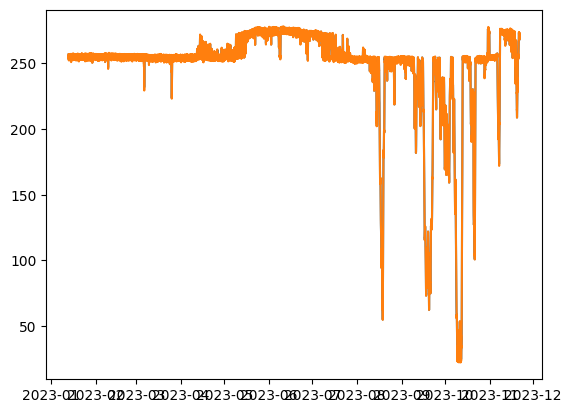

In [9]:
plt.plot(allDataHalfH)
plt.plot(allData)

## TRAINING

In [10]:
xgb = XGBRegressor()
lags = LAGS[0]

model = ForecasterAutoreg(regressor=xgb, lags=lags)

model.fit(trainingSet["Value"])


### PREDIZIONI SUI SET

#### TRANING SET

step 15251/15251

predizione sul Training set: 47 s
___SCORE___
mape: 0.001968701606953373
r2: 0.9930117564092135


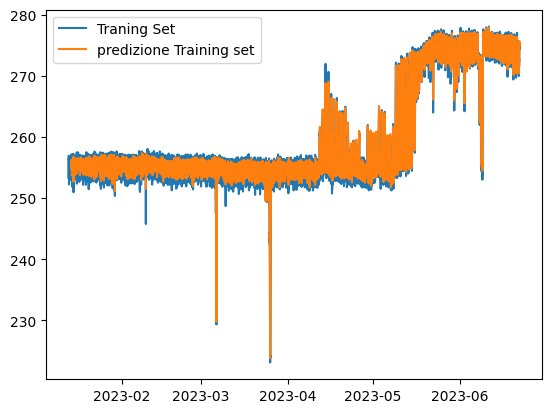

In [172]:
start = time.time()
predVal = predict(trainingSet, lags, STEPS)
end = time.time()
print(f"predizione sul Training set: {int(end-start)} s")
printScore(allData.loc[predVal.index].values, predVal.values)
plt.plot(trainingSet, label="Traning Set")
plt.plot(predVal, label="predizione Training set")
plt.legend()

#### VALIDATION SET

step 3741/3741

predizione sul validation set: 11 s
___SCORE___
mape: 0.0052383058596903774
r2: 0.9444069765579979


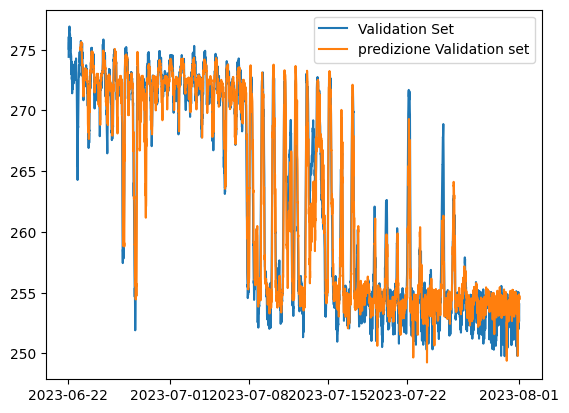

In [173]:
start = time.time()
predVal = predict(validationSet, lags, STEPS)
end = time.time()
print(f"predizione sul validation set: {int(end-start)} s")
printScore(allData.loc[predVal.index].values, predVal.values)
plt.plot(validationSet, label="Validation Set")
plt.plot(predVal, label="predizione Validation set")
plt.legend()

#### STRANGE SET

step 10721/10721

predizione sulo Strange set: 35 s


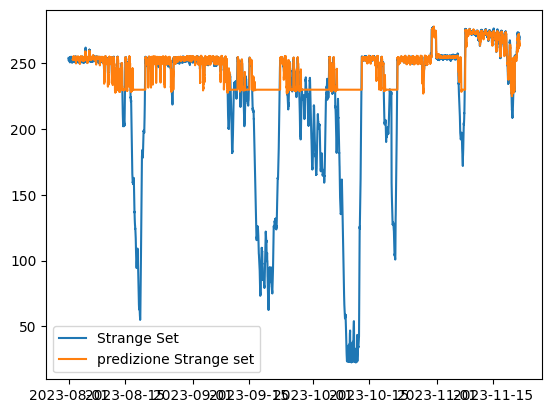

In [174]:
start = time.time()
predVal = predict(strangeData, LAGS[0], STEPS)
end = time.time()
print(f"predizione sul Strange set: {int(end-start)} s")
plt.plot(strangeData, label="Strange Set")
plt.plot(predVal, label="predizione Strange set")
plt.legend()

## TUNING IPERPARAMETRI XGBRegressor

In [12]:
reg = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", XGBRegressor())
])

In [13]:
forecast = ForecasterAutoreg(reg, lags)

In [14]:
forecast.fit(trainingSet["Value"])

In [15]:
predVal = predict(validationSet, lags, STEPS)
printScore(allData.loc[predVal.index].values, predVal.values)

step 3741/3741

___SCORE___
mape: 0.0052383058596903774
r2: 0.9444069765579979


In [16]:
param_grid = {
    "reg__max_depth": [7,8,9,10],
    "reg__eta": [0.3, 0.1, 0.01],
    "reg__subsample": np.linspace(0,1,5),
    "reg__colsample_bytree": np.linspace(0,1,5)
}

In [19]:
lags_grid = [24, 48, 96]

!LA CELLA SEGUENTE IMPIEGA 30 MINUTI CIRCA!

In [20]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = validationSet["Value"],
    param_grid  = param_grid,
    lags_grid   = lags_grid,
    steps       = 4*12,
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(validationSet)*0.8),
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)

Number of models compared: 900.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/300 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'reg__colsample_bytree': 1.0, 'reg__eta': 0.1, 'reg__max_depth': 9, 'reg__subsample': 0.75}
  Backtesting metric: 0.003965927664027289



In [21]:
res

,lags,params,mean_absolute_percentage_error,reg__colsample_bytree,reg__eta,reg__max_depth,reg__subsample
573,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'reg__colsample_bytree': 1.0, 'reg__eta': 0.1...",0.003966,1.00,0.10,9.0,0.75
861,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'reg__colsample_bytree': 1.0, 'reg__eta': 0.1...",0.003983,1.00,0.10,7.0,0.25
511,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'reg__colsample_bytree': 0.75, 'reg__eta': 0....",0.003985,0.75,0.10,9.0,0.25
747,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'reg__colsample_bytree': 0.5, 'reg__eta': 0.1...",0.003989,0.50,0.10,8.0,0.50
501,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'reg__colsample_bytree': 0.75, 'reg__eta': 0....",0.004002,0.75,0.10,7.0,0.25
...,...,...,...,...,...,...,...
190,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'reg__colsample_bytree': 0.75, 'reg__eta': 0....",0.042394,0.75,0.30,9.0,0.00
195,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'reg__colsample_bytree': 0.75, 'reg__eta': 0....",0.042394,0.75,0.30,10.0,0.00
200,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'reg__colsample_bytree': 0.75, 'reg__eta': 0....",0.042394,0.75,0.10,7.0,0.00
165,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'reg__colsample_bytree': 0.5, 'reg__eta': 0.0...",0.042394,0.50,0.01,8.0,0.00


In [157]:
xgb = XGBRegressor(colsample_bytree=1, eta=0.1, max_depth=9, subsample=0.75)
regrOK = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", xgb)
])
forecast = ForecasterAutoreg(regrOK, lags)

In [158]:
param_gridOK = {}
lags_grid = [48,96,144,192,240,288]

## Future Step 6 ore

In [159]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = trainingSet["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*6, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(trainingSet)*0.8), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)

Number of models compared: 6.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {}
  Backtesting metric: 0.007001928588906019



In [160]:
res

,lags,params,mean_absolute_percentage_error
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.007002
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.007708
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.008292
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.008368
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.009996
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.011590


In [162]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = trainingSet["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*6, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(trainingSet)*0.5), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 6.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144] 
  Parameters: {}
  Backtesting metric: 0.03546410026586739



,lags,params,mean_absolute_percentage_error
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035464
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035638
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035701
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.036038
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.036049
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.036395


## Future Step 12 ore

In [164]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = trainingSet["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*12, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(trainingSet)*0.8), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 6.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {}
  Backtesting metric: 0.0072735153028831686



,lags,params,mean_absolute_percentage_error
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.007274
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.007824
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.008791
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.008874
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.009919
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.011839


In [165]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = trainingSet["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*12, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(trainingSet)*0.5), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 6.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192] 
  Parameters: {}
  Backtesting metric: 0.035152098853919234



,lags,params,mean_absolute_percentage_error
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035152
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035219
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035310
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035685
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035928
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.036263


## Future Step 24 ore

In [166]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = trainingSet["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*24, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(trainingSet)*0.8), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 6.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192] 
  Parameters: {}
  Backtesting metric: 0.007497819449384305



,lags,params,mean_absolute_percentage_error
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.007498
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.007997
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.008505
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.008751
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.009013
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.011088


In [167]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = trainingSet["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*24, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(trainingSet)*0.5), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 6.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192] 
  Parameters: {}
  Backtesting metric: 0.03458957370580235



,lags,params,mean_absolute_percentage_error
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.034590
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.034652
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.034814
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035093
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035692
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035700


## Future Step 48 ore

In [168]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = trainingSet["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*48, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(trainingSet)*0.8), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 6.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144] 
  Parameters: {}
  Backtesting metric: 0.006658977968832391



,lags,params,mean_absolute_percentage_error
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.006659
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.006901
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.006940
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.007870
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.007971
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.012011


In [169]:
res = grid_search_forecaster(
    forecaster  = forecast,
    y           = trainingSet["Value"],
    param_grid  = param_gridOK,
    lags_grid   = lags_grid,
    steps       = 4*48, #DIFF
    metric      = 'mean_absolute_percentage_error',
    initial_train_size    = int(len(trainingSet)*0.5), #DIFF
    allow_incomplete_fold = False,
    return_best = True,
    verbose     = False    
)
res

Number of models compared: 6.


lags grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192] 
  Parameters: {}
  Backtesting metric: 0.03400372583019372



,lags,params,mean_absolute_percentage_error
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.034004
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.034245
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.034309
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.034947
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035025
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.035429


## TUNING IPERPARAMETRI di un altro regressor

## TESTS

Text(2023-09-26 08:00:00, 50, '___SCORE___\nmape: 0.1\nr2: 0.1')

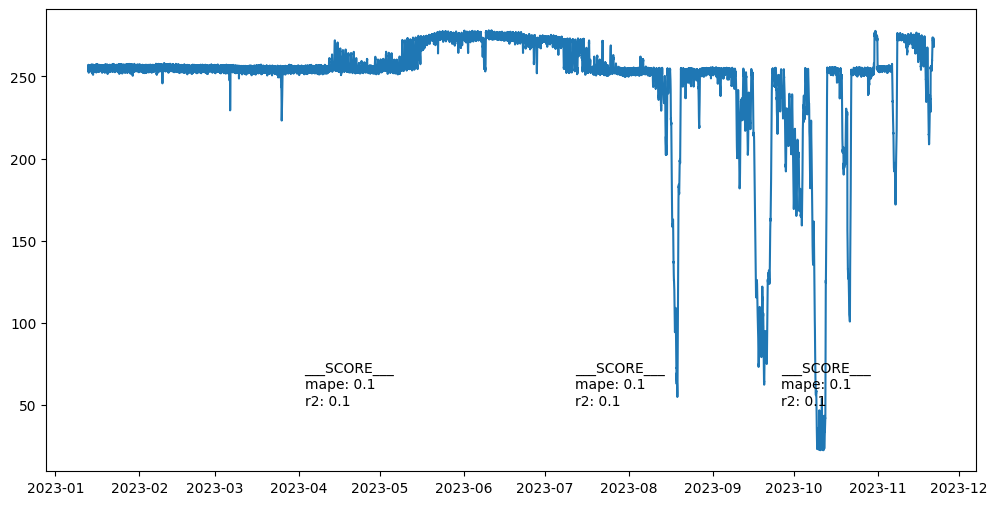

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
info = f"___SCORE___\nmape: 0.1\nr2: 0.1"
ax.plot(allData)
ax.annotate(info, (trainingSet.index[int(len(trainingSet)*0.5)],50))
ax.annotate(info, (validationSet.index[int(len(validationSet)*0.5)],50))
ax.annotate(info, (strangeData.index[int(len(strangeData)*0.5)],50))

In [180]:
from datetime import datetime

In [183]:
datetime.now().strftime("%d/%m/%Y %H:%M:%S")

'27/11/2023 12:56:35'